In [12]:
import pandas as pd
import json
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from pydriller import Repository

# Zorgt dat grafieken direct zichtbaar zijn
%matplotlib inline

In [23]:
import math

def calculate_sample_size(N, confidence_level=0.95, margin_of_error=0.10):
    """
    Berekent de steekproefgrootte n voor een populatie N.
    Standaard: 95% zekerheid, 10% foutmarge (om het haalbaar te houden voor mining).
    """
    if N == 0: return 0
    
    # Z-score voor 95% is 1.96
    Z = 1.96
    p = 0.5  # Worst-case schatting voor variantie (50%)
    e = margin_of_error
    
    # Formule van Cochran (aangepast voor eindige populatie)
    numerator = (Z**2 * p * (1-p)) / (e**2)
    n = numerator / (1 + ((numerator - 1) / N))
    
    return math.ceil(n)



In [24]:
FOLDER_PATH = os.path.join('Databestanden', 'Maven') 
ECOSYSTEM_NAME = "Java (Maven)"


print(f"--- START MINING VOOR: {ECOSYSTEM_NAME} ---")
print(f"Map: {FOLDER_PATH}")

--- START MINING VOOR: Java (Maven) ---
Map: Databestanden/Maven


In [15]:
def score_to_group(score):
    if score >= 9.0: return 'Critical'
    elif score >= 7.0: return 'High'
    elif score >= 4.0: return 'Medium'
    else: return 'Low'

def get_severity_group(entry, entry_id=""):
    """
    Bepaalt severity. Geeft 'None' terug voor Malware, 
    omdat we geen malware willen minen.
    """
    # 1. Malware negeren voor Mining
    if entry_id.startswith('MAL-'):
        return None 

    severity_str = None
    raw_sev = entry.get('severity')

    # 2. Check 'database_specific' (Cruciaal voor npm GHSA!)
    if 'database_specific' in entry:
        severity_str = entry['database_specific'].get('severity')

    # 3. Check root string
    if not severity_str and isinstance(raw_sev, str):
        severity_str = raw_sev

    # 4. Categoriseren op tekst
    if severity_str:
        s = severity_str.upper()
        if 'CRITICAL' in s: return 'Critical'
        if 'HIGH' in s: return 'High'
        if 'MODERATE' in s or 'MEDIUM' in s: return 'Medium'
        if 'LOW' in s: return 'Low'
    
    # 5. Categoriseren op score (lijst of getal)
    if isinstance(raw_sev, list):
        for item in raw_sev:
            if isinstance(item, dict) and isinstance(item.get('score'), (int, float)):
                return score_to_group(float(item['score']))
            if isinstance(item, dict) and item.get('type') in ['CVSS_V3', 'CVSS_V31']:
                 try: return score_to_group(float(item.get('score')))
                 except: pass

    if isinstance(raw_sev, (int, float)):
        return score_to_group(float(raw_sev))

    return None

In [16]:
candidates = {'Low': [], 'Medium': [], 'High': [], 'Critical': []}

if not os.path.exists(FOLDER_PATH):
    print(f"FOUT: Map niet gevonden: {FOLDER_PATH}")
else:
    files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.json')]
    total_files = len(files)
    print(f"Scannen van {total_files} bestanden op GitHub links...")

    counter = 0
    found_count = 0

    for filename in files:
        counter += 1
        if counter % 10000 == 0: print(f"   Gescand: {counter}/{total_files}...")

        if filename.startswith('MAL-'): continue

        try:
            with open(os.path.join(FOLDER_PATH, filename), 'r', encoding='utf-8') as f:
                entry = json.load(f)
                
                group = get_severity_group(entry, entry.get('id', filename))
                
                if group and 'references' in entry:
                    for ref in entry['references']:
                        url = ref.get('url', '')
                        # We zoeken specifieke commit links
                        if 'github.com' in url and '/commit/' in url:
                            candidates[group].append(url)
                            found_count += 1
                            break 
        except: continue

    print("-" * 30)
    print(f"Totaal GitHub fix-commits gevonden: {found_count}")
    for g, urls in candidates.items():
        print(f"  {g}: {len(urls)}")

Scannen van 6182 bestanden op GitHub links...
------------------------------
Totaal GitHub fix-commits gevonden: 2820
  Low: 143
  Medium: 1370
  High: 891
  Critical: 416


In [17]:
import math

def calculate_needed_sample(N, confidence_level=0.95, margin_of_error=0.10):
    """
    Berekent de steekproefgrootte n voor een populatie N.
    Standaard: 95% zekerheid, 10% foutmarge (om het haalbaar te houden voor mining).
    """
    if N == 0: return 0
    
    # Z-score voor 95% is 1.96
    Z = 1.96
    p = 0.5  # Worst-case schatting voor variantie (50%)
    e = margin_of_error
    
    # Formule van Cochran (aangepast voor eindige populatie)
    numerator = (Z**2 * p * (1-p)) / (e**2)
    n = numerator / (1 + ((numerator - 1) / N))
    
    return math.ceil(n)


In [18]:
if found_count == 0:
    print("Geen commits gevonden om te minen.")
else:
    to_mine = []
    print("\n--- STEEKPROEF BEREKENING (Stratified Sampling) ---")
    
    for g, urls in candidates.items():
        if urls:
            population_size = len(urls)
            
            # Hier berekenen we n specifiek voor DEZE groep
            needed_n = calculate_needed_sample(population_size, margin_of_error=0.10)
            
            # Veiligheidscheck: we kunnen niet meer minen dan we hebben
            # (Bijv. als formule 90 zegt, maar we hebben maar 50 links, pakken we er 50)
            final_n = min(len(urls), needed_n)
            
            print(f"Severity '{g}': Populatie={population_size} -> We minen er: {final_n}")
            
            # De daadwerkelijke loterij
            sample = random.sample(urls, final_n)
            for url in sample:
                to_mine.append({'group': g, 'url': url})

    print("-" * 40)
    print(f"Totaal te minen: {len(to_mine)} repositories.")
    print("-" * 40)


--- STEEKPROEF BEREKENING (Stratified Sampling) ---
Severity 'Low': Populatie=143 -> We minen er: 58
Severity 'Medium': Populatie=1370 -> We minen er: 90
Severity 'High': Populatie=891 -> We minen er: 87
Severity 'Critical': Populatie=416 -> We minen er: 79
----------------------------------------
Totaal te minen: 314 repositories.
----------------------------------------


In [21]:
# --- 3. Daadwerkelijk Minen (Zoals voorheen) ---
results = []
    
    # Pas dit aan als je even wilt testen (bijv. to_mine[:5] voor een snelle check)
mining_queue = to_mine 

for idx, item in enumerate(mining_queue):
        # Voortgangsindicator
    if (idx + 1) % 5 == 0 or idx == 0: 
        print(f"[{idx+1}/{len(mining_queue)}] Mining: {item['url']} ({item['group']})")
        
    try:
        parts = item['url'].split('/commit/')
        repo_url = parts[0]
        commit_hash = parts[1]
            
        for commit in Repository(repo_url, single=commit_hash).traverse_commits():
            results.append({
                'severity': item['group'],
                'url': item['url'],
                'fix_date': commit.author_date, 
                'insertions': commit.insertions,
                'deletions': commit.deletions,
                'files_changed': commit.files,
                'churn': commit.insertions + commit.deletions
            })
    except Exception as e:
        # print(f"Fout bij {item['url']}: {e}") # Zet aan als je fouten wilt zien
        pass

print(f"\nKlaar! {len(results)} commits succesvol gemined.")

[1/314] Mining: https://github.com/alkacon/opencms-core/commit/148f2126f61bf5fa3d9f8c669889ccab3b9dceac (Low)
[5/314] Mining: https://github.com/jenkinsci/coverity-plugin/commit/34b7c2b07014b8e1e708361170146600db172491 (Low)
[10/314] Mining: https://github.com/jenkinsci/qmetry-for-jira-test-management-plugin/commit/6711f566b72c099f10b1cecab406786ca998651d (Low)
[15/314] Mining: https://github.com/jenkinsci/structs-plugin/commit/84842216981976d920b568726f8590a7b39a56a1 (Low)
[20/314] Mining: https://github.com/xwiki/xwiki-platform/commit/6570f40f976aec82baf388b5239d1412cab238c9 (Low)
[25/314] Mining: https://github.com/apache/ranger/commit/8d89fec991f05bd92e28f459bc2b3a3024aaad82 (Low)
[30/314] Mining: https://github.com/liferay/liferay-portal/commit/0a82d906b3489330d4e8552abe1b19ec2605323e (Low)
[35/314] Mining: https://github.com/jenkinsci/m2release-plugin/commit/a2e7f2bb82640a9d3641265a19c86ba141a7e79c (Low)
[40/314] Mining: https://github.com/wildfly/wildfly-core/commit/06dd9884f6ba


DETAIL ANALYSE FIXES: Java (Maven)
          insertions  deletions  files_changed  churn
severity                                             
Low            422.6       83.4            7.7  506.0
Medium         177.9      444.8           10.3  622.7
High           862.2       43.2            5.1  905.3
Critical       112.1       63.4            4.9  175.5


/var/folders/s5/8b5j_kls30zg49cxlzy6rxl80000gn/T/ipykernel_17767/3629821572.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='severity', y='churn', data=df, order=order, jitter=True, size=7, palette="Set2")


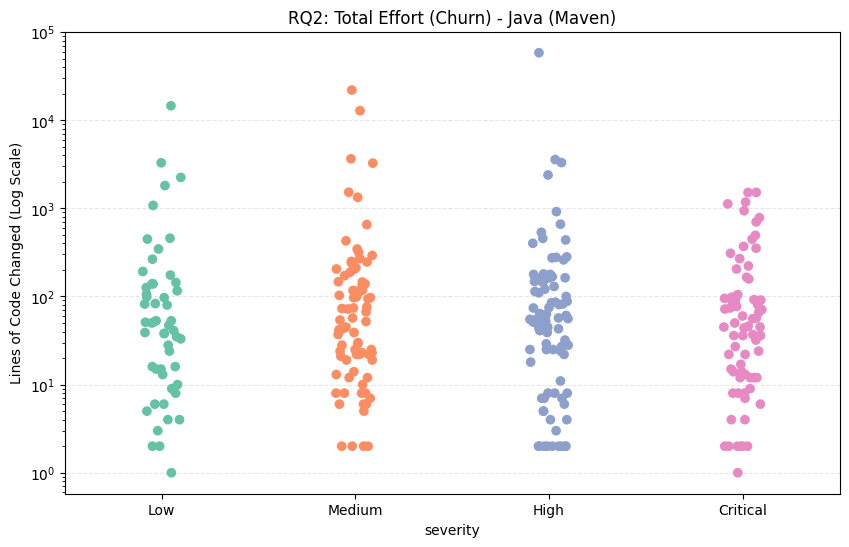

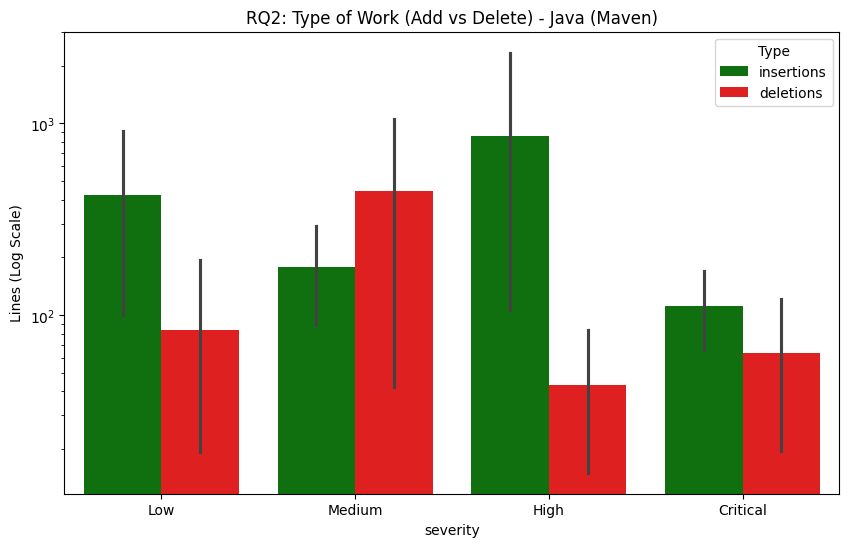

In [22]:
if results:
    df = pd.DataFrame(results)
    order = ['Low', 'Medium', 'High', 'Critical']
    
    print("\n" + "="*60)
    print(f"DETAIL ANALYSE FIXES: {ECOSYSTEM_NAME}")
    print("="*60)
    
    # We groeperen nu op severity en berekenen het gemiddelde van ALLES
    summary_table = df.groupby('severity')[['insertions', 'deletions', 'files_changed', 'churn']].mean().reindex(order)
    
    # Mooi printen (zonder decimalen voor regels code)
    print(summary_table.round(1))
    print("="*60)
    
    # --- PLOT 1: De Churn (zoals eerst) ---
    plt.figure(figsize=(10, 6))
    sns.stripplot(x='severity', y='churn', data=df, order=order, jitter=True, size=7, palette="Set2")
    plt.yscale('log') 
    plt.title(f'RQ2: Total Effort (Churn) - {ECOSYSTEM_NAME}')
    plt.ylabel('Lines of Code Changed (Log Scale)')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

    # --- PLOT 2 (NIEUW): Insertions vs Deletions ---
    # Dit laat zien: Wordt er vooral code geschreven (groen) of weggegooid (rood)?
    df_melt = df.melt(id_vars=['severity'], value_vars=['insertions', 'deletions'], var_name='Type', value_name='Lines')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='severity', y='Lines', hue='Type', data=df_melt, order=order, palette=['green', 'red'])
    plt.yscale('log')
    plt.title(f'RQ2: Type of Work (Add vs Delete) - {ECOSYSTEM_NAME}')
    plt.ylabel('Lines (Log Scale)')
    plt.show()

else:
    print("Geen data beschikbaar om te plotten.")